In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [2]:
import numpy as np  
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

## Load in Dataset

In [3]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000,)


In [4]:
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


## Build Model

In [5]:
i = Input(shape=x_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

## Compile and Fit

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#without data augmentation
# r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

- clear indicator of overfitting, training set accuracy is near 99% while validation leveled out at 84
- Need to augment data

In [8]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r = model.fit(train_generator, validation_data=(x_test, y_test), steps_per_epoch=steps_per_epoch, epochs=50)

Epoch 1/50
1562/1562 [==============================] - 19s 11ms/step - loss: 1.4613 - accuracy: 0.4878 - val_loss: 1.2497 - val_accuracy: 0.5805
Epoch 2/50
1562/1562 [==============================] - 16s 10ms/step - loss: 1.0060 - accuracy: 0.6492 - val_loss: 1.0079 - val_accuracy: 0.6669
Epoch 3/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.8617 - accuracy: 0.7019 - val_loss: 0.7962 - val_accuracy: 0.7266
Epoch 4/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.7683 - accuracy: 0.7361 - val_loss: 0.8554 - val_accuracy: 0.7140
Epoch 5/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.7020 - accuracy: 0.7590 - val_loss: 0.6329 - val_accuracy: 0.7853
Epoch 6/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.6485 - accuracy: 0.7788 - val_loss: 0.6073 - val_accuracy: 0.7995
Epoch 7/50
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5986 - accuracy: 0.7957 - val_loss: 0.6320 -

## Plot loss per iteration

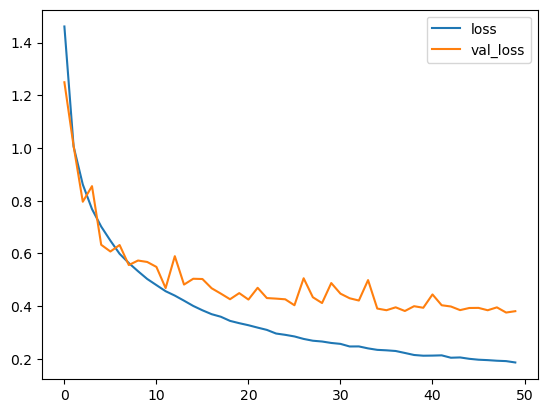

In [9]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Plot Accuracy per iteration

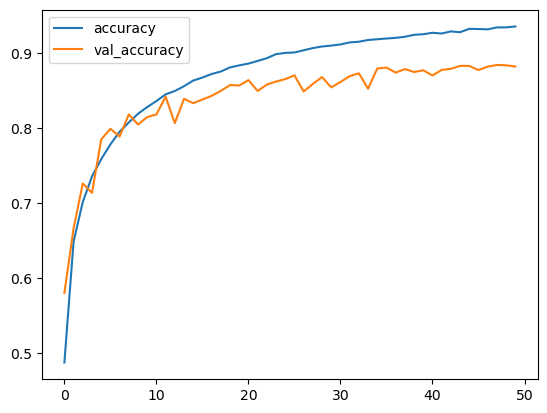

In [10]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Training Accuracy is converging, but we haven't imporved our model.
Clear indicator of overfitting

## Plotting Confusion Matrix

313/313 [==============================] - 1s 2ms/step
Confusion Matrix, without normalization
[[922   9  29   3   3   0   1   1  15  17]
 [  5 970   1   0   1   0   1   0   1  21]
 [ 25   1 852  28  29  24  21   8   6   6]
 [ 24   6  48 754  29  78  28  13   8  12]
 [ 14   2  29  25 889  20  15   4   1   1]
 [ 10   6  26 103  26 804   8   7   1   9]
 [ 10   1  32  26  12   7 907   1   2   2]
 [ 16   3  11  21  33  11   0 901   2   2]
 [ 45  21   8   3   1   0   3   1 906  12]
 [  9  50   1   4   2   0   3   0  10 921]]


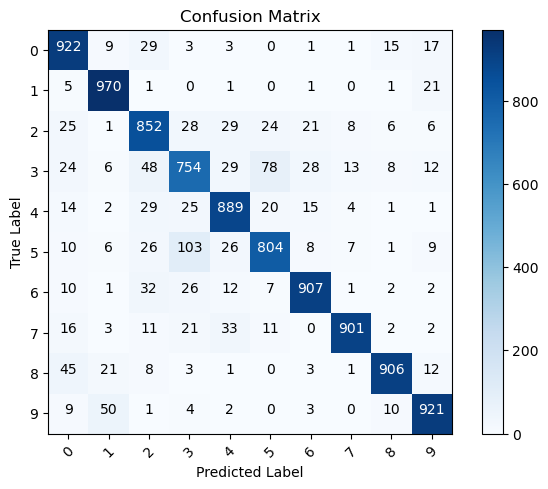

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh= cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [12]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

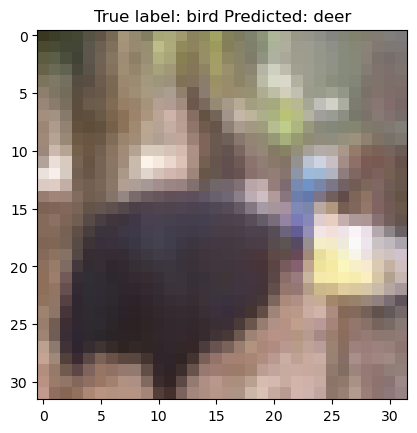

In [13]:
# misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0     